# BERT를 이용한 텍스트 분류
 BERT 및 Transformer 인코더 아키텍처는 NLP의 다양한 작업에서 큰 성공을 거두었습니다. 딥러닝 모델에 사용하기에 적합한 자연언어의 벡터 공간 표현을 계산한다. BERT 모델 제품군은 Transformer 인코더 아키텍처를 사용하여 전후의 모든 토큰의 전체 컨텍스트에서 입력 텍스트의 각 토큰을 처리하므로 : bidirectional encoder representations from Transformers

 BERT 모델은 일반적으로 사전학습된 모델을 사용하여 fine-tuning을 진행하여 사용한다.

In [ ]:
# pip install tensorflow_text
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

print(tf.__version__)
tf.get_logger().setLevel('ERROR')

2.8.4


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### IMDB 데이터를 활용한 감성 분석

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar = True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed = seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size = AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
        'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed = seed
)

val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
for test_batch, label_batch in train_ds.take(1):
    for i in range(1):
        print(test_batch.numpy()[0])
        print(label_batch.numpy()[0], class_names[label_batch.numpy()[0]])

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
0 neg


## 모델 선택
참고 url : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2

In [6]:
# 전처리 모델
bert_preprocess_model = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

bert_model = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2",
    trainable=True)

In [7]:
text_test = ['this is nice!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'keys : {list(text_preprocessed.keys())}')
print(f'shape : {text_preprocessed["input_word_ids"].shape}')
print(f'word ids : {text_preprocessed["input_word_ids"][0, :25]}')
print(f'input mask : {text_preprocessed["input_mask"][0, :25]}')
print(f'type ids : {text_preprocessed["input_type_ids"][0, :25]}')


keys : ['input_mask', 'input_word_ids', 'input_type_ids']
shape : (1, 128)
word ids : [ 101 2023 2003 3835  999  102    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
input mask : [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
type ids : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 모델 정의

In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
                             trainable=True,
                             name = 'BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.54555285]], shape=(1, 1), dtype=float32)


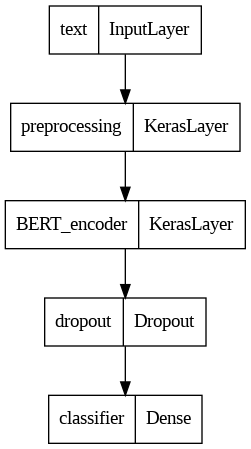

In [10]:
tf.keras.utils.plot_model(classifier_model)

In [11]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [12]:
epochs = 5
step_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = step_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr = init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [13]:
classifier_model.compile(optimizer=optimizer,
                         loss = loss,
                         metrics = metrics)

In [14]:
history = classifier_model.fit(x=train_ds,
                               validation_data = val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 813s 1s/step - loss: 0.4830 - binary_accuracy: 0.7451 - val_loss: 0.4027 - val_binary_accuracy: 0.8292
Epoch 2/5
625/625 [==============================] - 752s 1s/step - loss: 0.3270 - binary_accuracy: 0.8542 - val_loss: 0.3731 - val_binary_accuracy: 0.8482
Epoch 3/5
625/625 [==============================] - 745s 1s/step - loss: 0.2494 - binary_accuracy: 0.8965 - val_loss: 0.3944 - val_binary_accuracy: 0.8454
Epoch 4/5
625/625 [==============================] - 714s 1s/step - loss: 0.1928 - binary_accuracy: 0.9258 - val_loss: 0.4516 - val_binary_accuracy: 0.8562
Epoch 5/5
625/625 [==============================] - 725s 1s/step - loss: 0.1543 - binary_accuracy: 0.9416 - val_loss: 0.4691 - val_binary_accuracy: 0.8556


In [22]:
classifier_model.save('/content/drive/MyDrive/Colab Notebooks/git/Advanced Text Tutorial with BERT/Classify text with BERT/my_model',include_optimizer=False)

In [15]:
loss, accuracy = classifier_model.evaluate(test_ds)

782/782 [==============================] - 273s 348ms/step - loss: 0.4515 - binary_accuracy: 0.8542


In [16]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


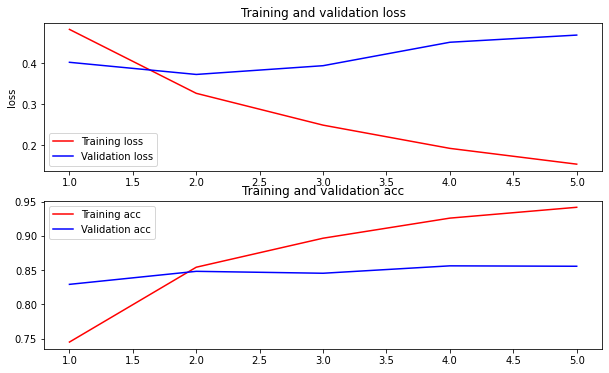

In [19]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10,6))
fig.tight_layout()

plt.subplot(2,1,1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()


In [23]:
load_model = tf.saved_model.load('/content/drive/MyDrive/Colab Notebooks/git/Advanced Text Tutorial with BERT/Classify text with BERT/my_model')